# Example: K-meams clustering of a consumer spending behavior dataset
In this example, we will use the K-means clustering algorithm to analyze a consumer behavior dataset. Fill me in.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
In this example, we'll work with a [customer spending preferences dataset from Kaggle](https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data?select=Mall_Customers.csv). This dataset was created learning customer segmentation concepts, known as [market basket analysis](https://en.wikipedia.org/wiki/Market_basket). We will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) analysis to explore this data.

> __What's in the dataset?__
> 
> Describe the data, the fields, and any relevant information about the dataset here.

We'll load the dataset by calling [the `MyKaggleCustomerSpendingDataset()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/#VLDataScienceMachineLearningPackage.MyKaggleCustomerSpendingDataset) which returns [a `DataFrame` instance](https://github.com/JuliaData/DataFrames.jl) containing the data. We'll save the data in the `originaldataset::DataFrame` variable.

In [2]:
originaldataset = MyKaggleCustomerSpendingDataset(); # load the dataset

__Hmmm__. We have [categorical fields](https://en.wikipedia.org/wiki/Categorical_variable). Let's remap the `gender::String7` categorical feature, which is a string, to a number, i.e., let `Male = -1` and `Female = 1.` It's much easier to use numbers than categorical data when looking at (and analyzing) this data later. 
> __Note__: the original dataset did not include example shoppers who identified as non-binary. Hence, we transformed the original `gender::String7` field to ${-1,1}$. However, if non-binary shoppers were to enter the dataset, we could map them to a different number, e.g., `0`.

We'll store the revised dataset in [the `dataset::DataFrame` variable](https://github.com/JuliaData/DataFrames.jl).

In [3]:
dataset = let
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :gender => ByRow( x-> (x=="Male" ? -1 : 1)) => :gender); # maps gender to -1,1
    treated_dataset 
end;

Ultimately, we need the raw numerical data and not [a `DataFrame` instance](https://dataframes.juliadata.org/stable/), so let's convert the `dataset::DataFrame` instance to the [`D::Matrix` variable](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix). Note that we select from column `2:end` because we don't need the `id` field in the data.

In [4]:
D = dataset[:,2:end] |> Matrix # build a data matrix, exclude the id column

200×4 Matrix{Int64}:
 -1  19   15  39
 -1  21   15  81
  1  20   16   6
  1  23   16  77
  1  31   17  40
  1  22   17  76
  1  35   18   6
  1  23   18  94
 -1  64   19   3
  1  30   19  72
  ⋮           
  1  32  103  69
 -1  33  113   8
  1  38  113  91
  1  47  120  16
  1  35  120  79
  1  45  126  28
 -1  32  126  74
 -1  32  137  18
 -1  30  137  83

### Constants
Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [5]:
n = nrow(dataset); # how many example data points do we have? (number of shoppers)
m = 4; # number of features of each shopper
maxiter = 20000; # maximum iterations of our K-means
K = 5; # number of clusters. Why do we pick 5?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [6]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#0077b6";
my_color_dictionary[3] = colorant"#00b4d8";
my_color_dictionary[4] = colorant"#ffc300";
my_color_dictionary[5] = colorant"#e36414";
my_color_dictionary[6] = colorant"#FF0000";

___

## Task 1: Initial visualization and data exploration
What does the consumer shopping data look like? Let's plot different data views to see if there are apparent patterns or groups in the dataset.

> `Unhide` the code block below to see how we plotted the dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and particularly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). An initial look at the data (`income` versus `spendingscore`) suggests that there are perhaps at least five groups (clusters) in the data. However, the groupings in other views, e.g., `age` versus `spending score,` are not as apparent.

Specify the horizontal and vertical axes columns. Note the column names of [type `Symbol`](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols), a special type unique string.

In [7]:
horizontal_column = :spendingscore; # x-axis {age | income | gender | spendingscore}
vertical_column = :income; # y-axis {age | income | gender | spendingscore}

So what do we see?

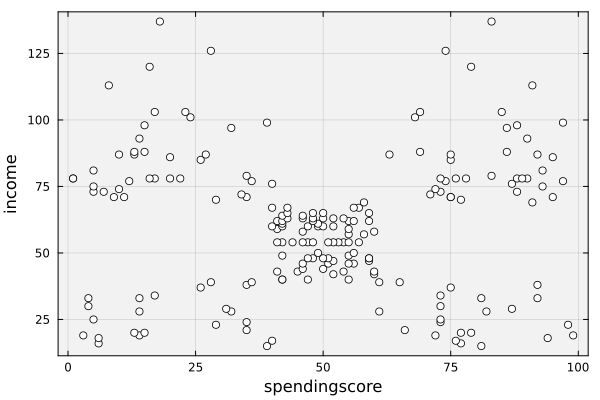

In [8]:
let
    
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot, styled the way we like
    scatter!(dataset[:, horizontal_column], dataset[:, vertical_column], label="", mec=:navy, c=:white)
    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

## Task 2: Naive K-means Implementation
In this task, we'll implement the K-means clustering algorithm that we discussed in the lecture. We've developed an [initial K-means implementation using the `cluster(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster). Let's explore how this implementation performs on our sample dataset. 

> __Buy versus Build__:
> 
> __Why?__ Why are we building our own K-means implementation when there are so many great implementations available? Good question! In practice, you would likely use an existing implementation. There is [already a good clustering package `Clustering.jl` that is available](https://github.com/JuliaStats/Clustering.jl) that exports [a `K-means` function](https://juliastats.org/Clustering.jl/stable/kmeans.html). However, in this demo, we'll use our implementation.
> 
> __Problem model__: Build [a `MyNaiveKMeansClusteringAlgorithm` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.MyNaiveKMeansClusteringAlgorithm), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.

We build the problem model using [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [9]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 10.0, # scale of the data
));

#### Visualize the initial centroids and assignments
The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in and _two derived (computed) fields_ that we computed in [the `build(...)` method](src/Factory.jl):
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_{1},\dots,\mu_{K}$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the cluster index that each data point is assigned to. We initialize the assignments randomly.


`Unhide` the code block below to see how we plotted the initial assignments and centroids. Each data point, i.e., feature vector (shown by the circles), is initially assigned to a random cluster, and the centroids dictionary is initialized randomly, where the centroids are shown as `+.`
* Depending upon the scale factor, the initial centroid values will be on the lower left of the plot. The features will be randomly dispersed throughout the plane. The centroids' positions and the features' classification will be updated with each iteration of the k-means algorithm.

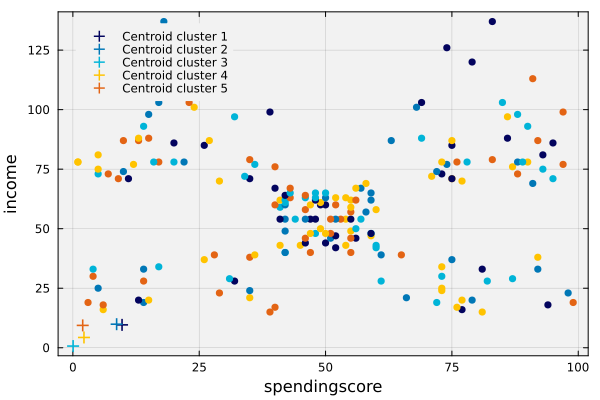

In [10]:
let

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
    vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
    assignments = copy(model.assignments);
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = copy(model.centroids);
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=6, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

### Clustering
We'll call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments (and returns the clustering results):

* __Data__: `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the feature vectors $\mathbf{x}\in\mathbb{R}^{m}$ as columns. Its values can be any subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* __Model__: `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, i.e.,  the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, the model can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why an abstract generic type?__ Suppose we have different K-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* __Verbose (optional)__: `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* __Measure (optional)__:`d::Any`. The optional distance argument is the $d(p,q)$ function and can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [ ]:
result = cluster(D, model, verbose = false); # cluster the data

`Unhide` the code block below to see how we plotted the clusters. The final clustering shows the values of each feature vector assigned to one of the `K`-clusters (different colors), with the centroid of each cluster shown as a `+` value.

In [ ]:
let

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
    vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
    assignments = result.assignments;
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result.centroids;
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=8, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

### What is in each cluster?
One obvious question is what is contained in each cluster. Specify the cluster index we want to look at in the `my_cluster_index::Int64` variable, and we'll build a table of the values in that cluster. We'll use [the `pretty_table(...)` method from the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl) to display the table.

In [ ]:
my_cluster_index = 1; # i ∈ {1,2,...,K}

So what do we see?

In [ ]:
let
    df = DataFrame(); 
    assignment = result.assignments;
    index_array = findall(a -> a == my_cluster_index, assignment);

    for i ∈ eachindex(index_array)
        a = index_array[i]; # what is the assignment
        row_df = (
                id = dataset[a,:id],
                c = my_cluster_index,
                gender = dataset[a,:gender],
                age = dataset[a,:age],
                income = dataset[a,:income],
                spendingscore = dataset[a, :spendingscore]
        );
        push!(df, row_df);
    end
    pretty_table(df, tf = tf_simple)
end

We can see the averages, i.e., the centroids of each feature in the `my_cluster_index::Int` by looking at the centroids dictionary:

In [ ]:
let
    μ = result.centroids[my_cluster_index]
    df = DataFrame();
    row_df = (
        c = my_cluster_index,
        gender = μ[1],
        age = μ[2],
        income = μ[3],
        spendingscore = μ[4]
    );
    push!(df, row_df);
    pretty_table(df, tf=tf_simple)
end

### Silhouette method
The silhouette method evaluates data consistency in clusters. The score ranges from -1 to 1; a high score means a data point fits well in its cluster but not in neighboring ones. The number of clusters $K$ is likely correct if most points score high. Conversely, many low scores suggest there may be too many or too few clusters. We'll consider the overall average score as a function of the number of clusters `K`.
* The silhouette method is exported by [the `Clustering.jl` package](https://github.com/JuliaStats/Clustering.jl), so let's choose the buy side of the buy versus bill trade and use the prebuilt implementation of clustering and evaluation of the performance of the clustering. 

In [ ]:
performance_array_silhouette = let

    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    M = deepcopy(model);
    tmp = Array{Float64,2}(undef, length(KA), 2);

    for i ∈ eachindex(KA)

        K = KA[i]; # how many clusters?
        R = kmeans(transpose(D), K; maxiter=maxiter, display=:none) # sensitive to the choice of maxiter
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), M, a; quality_index = :silhouettes)
        
        tmp[i,1] = K;
        tmp[i,2] = value;
    end
    tmp
end;

### Calinski–Harabasz index (CHI)
The [Calinski–Harabasz index (CHI)](https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index), also known as the Variance Ratio Criterion, is a widely used metric for assessing the quality of clustering algorithms. Introduced by [Tadeusz Caliński and Jerzy Harabasz in 1974](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101), it evaluates the clustering performance by comparing the ratio of between-cluster variance to within-cluster variance, with higher values indicating better-defined clusters
* The CHI method is exported by [the `Clustering.jl` package](https://github.com/JuliaStats/Clustering.jl), so let's choose the buy side of the buy versus bill trade and use the prebuilt implementation of clustering and evaluation of the performance of the clustering. 

In [ ]:
performance_array_CHI = let

    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    M = deepcopy(model);
    tmp = Array{Float64,2}(undef, length(KA), 2);

    for i ∈ eachindex(KA)

        K = KA[i]; # how many clusters?
        R = kmeans(transpose(D), K; maxiter=maxiter, display=:none) # sensitive to the choice of maxiter
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), M, a; quality_index = :calinski_harabasz)
        
        tmp[i,1] = K;
        tmp[i,2] = value;
    end
    tmp
end;

## Extra: Do you want to watch each iteration?
If the `verbose::Bool` flag is set to `true,` then a save file holding information about the algorithm progress will be written at each iteration. We can reload that data to generate plots of cluster assignments and centroid values as the algorithm works. 
* To do this, set the `write_the_kmeans_movie_frames::Bool` variable to `true.` The frames will then be written to the `frames` directory. Otherwise, to not write the images, set the `write_the_kmeans_movie_frames::Bool` to a value of `false`.

In [ ]:
write_the_kmeans_movie_frames = false;

In [ ]:
let

    if (write_the_kmeans_movie_frames == true)
    
        # get some data from the run -
        number_of_iterations = result.loopcount; # how many steps before we terminated
    
        # setup information for the plot -
        horizontal_column = :spendingscore
        vertical_column = :income
        horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
        vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
        for i ∈ 1:number_of_iterations
            data = load(joinpath(_PATH_TO_TMP, "data-$(i).jld2")); # load data for iteration i

            p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
            assignments = data["assignments"];
            for i ∈ eachindex(assignments);
                a = assignments[i];        
                scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
            end
    
            # plot the centroids -
            centroids = data["centroids"];
            for k ∈ 1:K
                c = centroids[k]
                scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
                    ms=6, markerstrokewidth=2, markershape = :plus)
            end
            current();
            savefig(joinpath(_PATH_TO_FRAMES, "Tmp-$(i).pdf"))
            # IJulia.clear_output(true)
        end
    end
end

## Summary
One direct summary sentence goes here

> __Key takeaways:__
> 
> Three key takeaways go here.


One direct concluding sentence goes here
___